# Neural Network Models for Classification of Alzheimer's disease stages

## 1.0 Introduction

Diagnoses and treatments for neurodegenerative disorders like Alzheimer's disease are extremely difficult (Dokholyan, Mohs and Bateman, 2022; Shusharina et al., 2023). Magnetic Resonance Imaging (MRI) scans are now useful instruments for the early diagnosis and categorization of Alzheimer's disease because to developments in medical imaging technology (Aramadaka et al., 2023). In this work, we make use of an MRI scan dataset from individuals with Alzheimer's disease who were divided into four groups: Very Mild Demented, Moderately Demented, NonDemented, and Mildly Demented.

Our main goal is to create and evaluate neural network models that can accurately classify Alzheimer's disease stages using MRI scan data. In order to begin this trip, we build two fundamental neural networks: a convolutional neural network (CNN) and a simple neural network. These baseline models provide us with a basis for comparing them to their enhanced equivalents.

In addition, we present two enhanced neural network topologies, acknowledging the need for model improvement to attain better performance. One is an upgraded Convolutional Neural Network, and the other is an enhanced Simple Neural Network. These improved models include structural changes as well as tweaks to the training process designed to improve classification robustness and accuracy.

We hope to clarify the effectiveness of the suggested enhancements and identify the influence of architectural modifications on neural network classification performance in identifying Alzheimer's disease stages from MRI images through this comparative investigation. These discoveries have the potential to improve Alzheimer's disease diagnosis techniques and aid in the creation of better medical decision support systems.

### 1.1 Imports

In [1]:
# Neural Networks:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm



# Metrics:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 1.2 Load Datasets

In [2]:
import torch

# Root File Location of the Data:
file_loc = "C:\\Users\\30081736\\OneDrive - University of South Wales\\New folder\\MS4S16 Coursework Dataset"

# Training Data Location:
load_train = f'{file_loc}\\train_data.pt'
load_train_labels = f'{file_loc}\\train_labels.pt'

# Testing Data Location:
load_test = f'{file_loc}\\test_data.pt'
load_test_labels = f'{file_loc}\\test_labels.pt'

# Load Training and Testing Data:
train_images = torch.load(load_train)
test_images = torch.load(load_test)
train_labels = torch.load(load_train_labels)
test_labels = torch.load(load_test_labels)

### 1.3 View Datasets

In [3]:
train_images.shape, test_images.shape

(torch.Size([5121, 3, 208, 176]), torch.Size([1279, 3, 208, 176]))

The result above shows that for our train images we have 5121 images in the training dataset and each image has 3 channels, typically representing the red, green, and blue color channels and also the height and width of each images, which is 208 pixels and 176 pixels respectively.

While for the test images shows that we have 1279 images in the testing dataset and each image has 3 channels, typically representing the red, green, and blue color channels and also the height and width of each images, which is 208 pixels and 176 pixels respectively.

In [4]:
import matplotlib.pyplot as plt

The Corresponding Label is: 3


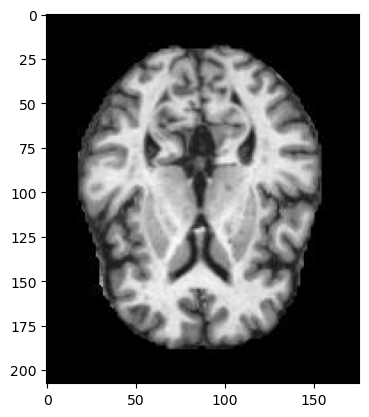

In [5]:
#Selecting the 501st sample

sample_num = 500
print(f'The Corresponding Label is: {train_labels[sample_num]}')
plt.imshow(train_images[sample_num][0], cmap='gray')
plt.show()

### 1.4 Flatten Data

In [6]:
train_images.shape[3]

176

In [7]:
train_images = train_images.view(train_images.shape[0], train_images.shape[1]*train_images.shape[2]*train_images.shape[3])
test_images = test_images.view(test_images.shape[0], test_images.shape[1]*test_images.shape[2]*test_images.shape[3])

In [8]:
print(train_images.shape, test_images.shape)
print(train_images.type(), test_images.type())
print(train_labels.type(), test_labels.type())

torch.Size([5121, 109824]) torch.Size([1279, 109824])
torch.FloatTensor torch.FloatTensor
torch.LongTensor torch.LongTensor


## 2.0 Simple Neural Network

### 2.1 Using a Standard Model

In [9]:
# Create a different style network. 
class Simple_NN1(nn.Module):
    
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x))

        return x

In [10]:
def train(model, images, labels, epochs, batch_size, lr):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("running on the GPU")
    else:
        device = torch.device("cpu")
        print("running on the CPU")
    model.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer =  torch.optim.SGD(model.parameters(), lr=lr)
    
    # Training Loop:
    for epoch in range(epochs):
        for i in tqdm(range(0, len(images), batch_size)):
            # Batching the Data:
            batch_data = images[i:i+batch_size]
            batch_labels =labels[i:i+batch_size]
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # 1) Calculating the Output of Model:
            y_predicted = model.forward(batch_data)

            # 2) Calculating the Error:
            loss = loss_function(y_predicted, batch_labels)

            # 3) Calculating the Gradients
            model.zero_grad()
            loss.backward() 

            # 4) Update the Gradients:
            optimizer.step()

        print(f"Iteration {epoch} | Loss: {loss}")

In [11]:
def test(model, images, labels):
    model.to('cpu') 

    with torch.no_grad():
        y_predicted = model.forward(images)

    print(f"Data Examples: {y_predicted[0]} \n\n{labels[0]}")

    predicted_classes = torch.argmax(y_predicted, dim = 1)
    print(predicted_classes[0:5])
    print(labels[0:5])


    # Accuracy:
    correct = 0
    total = 0

    for i in range(len(predicted_classes)):
        if predicted_classes[i] == labels[i]:
            correct += 1
        total += 1

    print(f"Accuracy: {round((correct/total)*100, 3)}")

    # Confusion Matrix:

    conf_matrix = confusion_matrix(labels, predicted_classes)
    print(conf_matrix)
    

In [12]:
net = Simple_NN1(n_features=109824)

In [13]:
torch.manual_seed(123)
train(net, train_images, train_labels, epochs=10, batch_size=100, lr=0.01)
test(net, test_images, test_labels)

running on the GPU


  0%|          | 0/52 [00:00<?, ?it/s]C:\Users\30081736\AppData\Local\Temp\ipykernel_2176\3351103809.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc4(x))
100%|██████████| 52/52 [00:01<00:00, 31.36it/s]


Iteration 0 | Loss: 0.9299381971359253


100%|██████████| 52/52 [00:00<00:00, 86.80it/s]


Iteration 1 | Loss: 0.9321416020393372


100%|██████████| 52/52 [00:00<00:00, 87.09it/s]


Iteration 2 | Loss: 0.914887547492981


100%|██████████| 52/52 [00:00<00:00, 86.23it/s]


Iteration 3 | Loss: 0.8844113349914551


100%|██████████| 52/52 [00:00<00:00, 87.98it/s]


Iteration 4 | Loss: 0.8435837030410767


100%|██████████| 52/52 [00:00<00:00, 86.51it/s]


Iteration 5 | Loss: 0.8306544423103333


100%|██████████| 52/52 [00:00<00:00, 84.27it/s]


Iteration 6 | Loss: 0.8231399059295654


100%|██████████| 52/52 [00:00<00:00, 90.83it/s]


Iteration 7 | Loss: 0.8185643553733826


100%|██████████| 52/52 [00:00<00:00, 90.74it/s]


Iteration 8 | Loss: 0.8158040046691895


100%|██████████| 52/52 [00:00<00:00, 90.74it/s]


Iteration 9 | Loss: 0.810258150100708
Data Examples: tensor([-4.2056, -5.7383, -0.2319, -1.6669]) 

3
tensor([2, 2, 2, 2, 2])
tensor([3, 2, 2, 0, 0])
Accuracy: 50.743
[[  0   0 166  13]
 [  0   0  12   0]
 [  0   0 639   1]
 [  0   0 438  10]]


## 3.0 Convolutional Neural Network

### 3.1 First Step

Convolutional neural networks have an additional layer of complexity because, in the middle of the network, multi-dimensional data is processed instead of single-dimensional data (tabular data). Before we can alter the shape of our data, or as we would say, FLATTEN it, we must first comprehend its current form.

In [14]:
import torch

# Root File Location of the Data:
file_loc = "C:\\Users\\30081736\\OneDrive - University of South Wales\\New folder\\MS4S16 Coursework Dataset"

# Training Data Location:
load_train = f'{file_loc}\\train_data.pt'
load_train_labels = f'{file_loc}\\train_labels.pt'

# Testing Data Location:
load_test = f'{file_loc}\\test_data.pt'
load_test_labels = f'{file_loc}\\test_labels.pt'

# Load Training and Testing Data:
train_images_conv = torch.load(load_train)
test_images_conv = torch.load(load_test)
train_labels_conv = torch.load(load_train_labels).to(torch.long)
test_labels_conv = torch.load(load_test_labels).to(torch.long)

In [15]:
class Conv_NN(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        
        # Convolutional Layers & Max Pooling Layer Defined:
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=16, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        print(f"Step 1: Shape of Data before Flattening: {x.shape}")

        return x

In [16]:
net  = Conv_NN(n_channels = 3)

In [17]:
n_samples = 10
test_output = net.forward(train_images_conv[0:n_samples])

Step 1: Shape of Data before Flattening: torch.Size([10, 32, 49, 41])


In [18]:
n_dimensions = 1
myfunc = nn.Flatten(n_dimensions)

test_output2 = myfunc(test_output)
print(f"The Shape after using the Flatten Function is: {test_output2.shape}")

The Shape after using the Flatten Function is: torch.Size([10, 64288])


### 3.2 Step 2

Now that we understand how to flatten our data, and how many features it is going to flatten into (64288) we can finish the structure of the network.

In [19]:
class Conv_NN(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        
        # Convolutional Layers & Max Pooling Layer Defined:
        self.conv1 = nn.Conv2d(in_channels = n_channels, out_channels = 16, kernel_size = (5,5) )
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32,  kernel_size = (5,5))
        self.pool = nn.MaxPool2d((2,2))
        
        # Flatten Data:
        self.flatten = nn.Flatten(1)
        
        # Linear Layers:
        self.fc1 = nn.Linear(64288, 1000)
        self.fc2 = nn.Linear(1000, 4)
        
    def forward(self, x):
        # Step 1: Convolutional Layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # print(f"Step 1: Shape of Data before Flattening: {x.shape}")


        # Step 2: Flatten Data & Linear Layers
        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)

        return x

In [20]:
net = Conv_NN(n_channels=3)

In [21]:
torch.manual_seed(123)
train(net, train_images_conv, train_labels_conv, epochs=10, batch_size=100, lr=0.01)
test(net, test_images_conv, test_labels_conv)

running on the GPU


100%|██████████| 52/52 [00:05<00:00,  9.48it/s]


Iteration 0 | Loss: 0.93439781665802


100%|██████████| 52/52 [00:03<00:00, 14.89it/s]


Iteration 1 | Loss: 0.9214170575141907


100%|██████████| 52/52 [00:03<00:00, 14.87it/s]


Iteration 2 | Loss: 0.8822840452194214


100%|██████████| 52/52 [00:03<00:00, 14.64it/s]


Iteration 3 | Loss: 0.8645033240318298


100%|██████████| 52/52 [00:03<00:00, 15.09it/s]


Iteration 4 | Loss: 0.8560925722122192


100%|██████████| 52/52 [00:03<00:00, 15.07it/s]


Iteration 5 | Loss: 0.8497775793075562


100%|██████████| 52/52 [00:03<00:00, 15.06it/s]


Iteration 6 | Loss: 0.8398314118385315


100%|██████████| 52/52 [00:03<00:00, 15.04it/s]


Iteration 7 | Loss: 0.8347710967063904


100%|██████████| 52/52 [00:03<00:00, 15.06it/s]


Iteration 8 | Loss: 0.8291653394699097


100%|██████████| 52/52 [00:03<00:00, 15.05it/s]


Iteration 9 | Loss: 0.8217146992683411
Data Examples: tensor([-4.5631, -5.2716, -0.2357, -1.6377]) 

3
tensor([2, 2, 2, 2, 2])
tensor([3, 2, 2, 0, 0])
Accuracy: 51.681
[[  0   0 163  16]
 [  0   0  12   0]
 [  0   0 638   2]
 [  0   0 425  23]]


## 4.0 Improved Simple Neural Network

In [22]:
import torch.optim as optim

class Improved_NN(nn.Module):
    
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 4)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return F.log_softmax(x, dim=1)

In [23]:
net = Improved_NN(n_features=109824)

In [24]:
torch.manual_seed(123)
train(net, train_images, train_labels, epochs=60, batch_size=40, lr=0.01)
test(net, test_images, test_labels)

running on the GPU


100%|██████████| 129/129 [00:01<00:00, 122.73it/s]


Iteration 0 | Loss: 0.37766146659851074


100%|██████████| 129/129 [00:00<00:00, 155.87it/s]


Iteration 1 | Loss: 0.3112022876739502


100%|██████████| 129/129 [00:00<00:00, 159.64it/s]


Iteration 2 | Loss: 0.2509259283542633


100%|██████████| 129/129 [00:00<00:00, 161.44it/s]


Iteration 3 | Loss: 0.18750832974910736


100%|██████████| 129/129 [00:00<00:00, 159.64it/s]


Iteration 4 | Loss: 0.14119938015937805


100%|██████████| 129/129 [00:00<00:00, 154.46it/s]


Iteration 5 | Loss: 0.11432082951068878


100%|██████████| 129/129 [00:00<00:00, 160.16it/s]


Iteration 6 | Loss: 0.09977662563323975


100%|██████████| 129/129 [00:00<00:00, 160.02it/s]


Iteration 7 | Loss: 0.08960376679897308


100%|██████████| 129/129 [00:00<00:00, 161.23it/s]


Iteration 8 | Loss: 0.07760096341371536


100%|██████████| 129/129 [00:00<00:00, 161.23it/s]


Iteration 9 | Loss: 0.06296690553426743


100%|██████████| 129/129 [00:00<00:00, 161.84it/s]


Iteration 10 | Loss: 0.05295274779200554


100%|██████████| 129/129 [00:00<00:00, 162.04it/s]


Iteration 11 | Loss: 0.04409760609269142


100%|██████████| 129/129 [00:00<00:00, 158.27it/s]


Iteration 12 | Loss: 0.02442040666937828


100%|██████████| 129/129 [00:00<00:00, 160.99it/s]


Iteration 13 | Loss: 0.019090723246335983


100%|██████████| 129/129 [00:00<00:00, 161.03it/s]


Iteration 14 | Loss: 0.024556158110499382


100%|██████████| 129/129 [00:00<00:00, 157.69it/s]


Iteration 15 | Loss: 0.024795278906822205


100%|██████████| 129/129 [00:00<00:00, 153.92it/s]


Iteration 16 | Loss: 0.019998466596007347


100%|██████████| 129/129 [00:00<00:00, 155.03it/s]


Iteration 17 | Loss: 0.031953632831573486


100%|██████████| 129/129 [00:00<00:00, 161.03it/s]


Iteration 18 | Loss: 0.021764829754829407


100%|██████████| 129/129 [00:00<00:00, 154.85it/s]


Iteration 19 | Loss: 0.04145415872335434


100%|██████████| 129/129 [00:00<00:00, 158.46it/s]


Iteration 20 | Loss: 0.01060410588979721


100%|██████████| 129/129 [00:00<00:00, 154.29it/s]


Iteration 21 | Loss: 0.00782377552241087


100%|██████████| 129/129 [00:00<00:00, 157.49it/s]


Iteration 22 | Loss: 0.012310239486396313


100%|██████████| 129/129 [00:00<00:00, 162.04it/s]


Iteration 23 | Loss: 0.015106556937098503


100%|██████████| 129/129 [00:00<00:00, 152.11it/s]


Iteration 24 | Loss: 0.007148759439587593


100%|██████████| 129/129 [00:00<00:00, 158.49it/s]


Iteration 25 | Loss: 0.011418585665524006


100%|██████████| 129/129 [00:00<00:00, 161.84it/s]


Iteration 26 | Loss: 0.029838819056749344


100%|██████████| 129/129 [00:00<00:00, 161.64it/s]


Iteration 27 | Loss: 0.014911852777004242


100%|██████████| 129/129 [00:00<00:00, 161.44it/s]


Iteration 28 | Loss: 0.05936374142765999


100%|██████████| 129/129 [00:00<00:00, 161.03it/s]


Iteration 29 | Loss: 0.009727457538247108


100%|██████████| 129/129 [00:00<00:00, 162.45it/s]


Iteration 30 | Loss: 0.1065068170428276


100%|██████████| 129/129 [00:00<00:00, 160.22it/s]


Iteration 31 | Loss: 0.003153234953060746


100%|██████████| 129/129 [00:00<00:00, 160.52it/s]


Iteration 32 | Loss: 0.04331674426794052


100%|██████████| 129/129 [00:00<00:00, 161.33it/s]


Iteration 33 | Loss: 0.015302515588700771


100%|██████████| 129/129 [00:00<00:00, 161.73it/s]


Iteration 34 | Loss: 8.725739462533966e-05


100%|██████████| 129/129 [00:00<00:00, 155.22it/s]


Iteration 35 | Loss: 0.02654240094125271


100%|██████████| 129/129 [00:00<00:00, 151.75it/s]


Iteration 36 | Loss: 0.059374526143074036


100%|██████████| 129/129 [00:00<00:00, 160.89it/s]


Iteration 37 | Loss: 0.00752211594954133


100%|██████████| 129/129 [00:00<00:00, 161.02it/s]


Iteration 38 | Loss: 0.00844703707844019


100%|██████████| 129/129 [00:00<00:00, 160.60it/s]


Iteration 39 | Loss: 0.009975343011319637


100%|██████████| 129/129 [00:00<00:00, 159.48it/s]


Iteration 40 | Loss: 0.005787638947367668


100%|██████████| 129/129 [00:00<00:00, 160.51it/s]


Iteration 41 | Loss: 4.303362584323622e-05


100%|██████████| 129/129 [00:00<00:00, 160.84it/s]


Iteration 42 | Loss: 0.00726474542170763


100%|██████████| 129/129 [00:00<00:00, 161.42it/s]


Iteration 43 | Loss: 0.01562472339719534


100%|██████████| 129/129 [00:00<00:00, 161.15it/s]


Iteration 44 | Loss: 0.00021789084712509066


100%|██████████| 129/129 [00:00<00:00, 161.22it/s]


Iteration 45 | Loss: 0.012631882913410664


100%|██████████| 129/129 [00:00<00:00, 162.22it/s]


Iteration 46 | Loss: 0.005826038774102926


100%|██████████| 129/129 [00:00<00:00, 161.05it/s]


Iteration 47 | Loss: 0.03276625648140907


100%|██████████| 129/129 [00:00<00:00, 161.70it/s]


Iteration 48 | Loss: 0.0037182497326284647


100%|██████████| 129/129 [00:00<00:00, 163.08it/s]


Iteration 49 | Loss: 0.29636070132255554


100%|██████████| 129/129 [00:00<00:00, 161.54it/s]


Iteration 50 | Loss: 0.013881566002964973


100%|██████████| 129/129 [00:00<00:00, 161.55it/s]


Iteration 51 | Loss: 0.001910767168737948


100%|██████████| 129/129 [00:00<00:00, 161.63it/s]


Iteration 52 | Loss: 0.048736415803432465


100%|██████████| 129/129 [00:00<00:00, 161.31it/s]


Iteration 53 | Loss: 0.03296836093068123


100%|██████████| 129/129 [00:00<00:00, 160.96it/s]


Iteration 54 | Loss: 0.038055989891290665


100%|██████████| 129/129 [00:00<00:00, 152.48it/s]


Iteration 55 | Loss: 0.007114671170711517


100%|██████████| 129/129 [00:00<00:00, 153.38it/s]


Iteration 56 | Loss: 0.0005981324939057231


100%|██████████| 129/129 [00:00<00:00, 161.15it/s]


Iteration 57 | Loss: 0.05820339918136597


100%|██████████| 129/129 [00:00<00:00, 161.24it/s]


Iteration 58 | Loss: 0.0026160799898207188


100%|██████████| 129/129 [00:00<00:00, 160.64it/s]


Iteration 59 | Loss: 0.02564302086830139
Data Examples: tensor([-3.9967, -6.6517, -0.5289, -0.9389]) 

3
tensor([2, 2, 2, 3, 2])
tensor([3, 2, 2, 0, 0])
Accuracy: 56.529
[[  3   0  96  80]
 [  1   0   4   7]
 [  0   0 474 166]
 [  0   0 202 246]]


## 5.0 Improved Convolutional Neural Network

In [25]:
class Conv_NN2(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        
        # Convolutional Layers & Max Pooling Layer Defined:
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        print(f"Step 1: Shape of Data before Flattening: {x.shape}")

        return x

In [26]:
net = Conv_NN2(n_channels=3)

In [27]:
n_samples = 10
test_output = net.forward(train_images_conv[0:n_samples])

Step 1: Shape of Data before Flattening: torch.Size([10, 64, 49, 41])


In [28]:
n_dimensions = 1
myfunc = nn.Flatten(n_dimensions)

test_output2 = myfunc(test_output)
print(f"The Shape after using the Flatten Function is: {test_output2.shape}")

The Shape after using the Flatten Function is: torch.Size([10, 128576])


In [29]:
class Conv_NN2(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        
        # Convolutional Layers & Max Pooling Layer Defined:
        self.conv1 = nn.Conv2d(in_channels = n_channels, out_channels = 32, kernel_size = (5,5) )
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64,  kernel_size = (5,5))
        self.pool = nn.MaxPool2d((2,2))
        
        # Flatten Data:
        self.flatten = nn.Flatten(1)
        
        # Linear Layers:
        self.fc1 = nn.Linear(128576, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 200)
        self.fc4 = nn.Linear(200, 100)
        self.fc5 = nn.Linear(100, 4)
        
    def forward(self, x):
        # Convolutional Layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)


        # Flatten Data & Linear Layers
        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)

        return x

In [30]:
torch.manual_seed(123)
net = Conv_NN2(n_channels=3)

In [31]:
train(net, train_images_conv, train_labels_conv, epochs=50, batch_size=30, lr=0.01)
test(net, test_images_conv, test_labels_conv)

running on the GPU


100%|██████████| 171/171 [00:06<00:00, 27.87it/s]


Iteration 0 | Loss: 0.9238728284835815


100%|██████████| 171/171 [00:06<00:00, 27.36it/s]


Iteration 1 | Loss: 0.9369498491287231


100%|██████████| 171/171 [00:06<00:00, 27.89it/s]


Iteration 2 | Loss: 0.9260281920433044


100%|██████████| 171/171 [00:06<00:00, 27.86it/s]


Iteration 3 | Loss: 0.8967776298522949


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 4 | Loss: 0.917402982711792


100%|██████████| 171/171 [00:06<00:00, 27.87it/s]


Iteration 5 | Loss: 0.9333367347717285


100%|██████████| 171/171 [00:06<00:00, 27.46it/s]


Iteration 6 | Loss: 0.9576098322868347


100%|██████████| 171/171 [00:06<00:00, 27.86it/s]


Iteration 7 | Loss: 0.9559388160705566


100%|██████████| 171/171 [00:06<00:00, 27.54it/s]


Iteration 8 | Loss: 0.9512723088264465


100%|██████████| 171/171 [00:06<00:00, 27.53it/s]


Iteration 9 | Loss: 0.9516888856887817


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 10 | Loss: 0.9538338780403137


100%|██████████| 171/171 [00:06<00:00, 27.76it/s]


Iteration 11 | Loss: 0.9397611021995544


100%|██████████| 171/171 [00:06<00:00, 26.93it/s]


Iteration 12 | Loss: 0.9207851886749268


100%|██████████| 171/171 [00:06<00:00, 27.41it/s]


Iteration 13 | Loss: 0.9050249457359314


100%|██████████| 171/171 [00:06<00:00, 27.13it/s]


Iteration 14 | Loss: 0.8689207434654236


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 15 | Loss: 0.8371754884719849


100%|██████████| 171/171 [00:06<00:00, 27.19it/s]


Iteration 16 | Loss: 0.7974241971969604


100%|██████████| 171/171 [00:06<00:00, 27.56it/s]


Iteration 17 | Loss: 0.7382000088691711


100%|██████████| 171/171 [00:06<00:00, 27.26it/s]


Iteration 18 | Loss: 0.6695002913475037


100%|██████████| 171/171 [00:06<00:00, 27.91it/s]


Iteration 19 | Loss: 0.5686247944831848


100%|██████████| 171/171 [00:06<00:00, 27.88it/s]


Iteration 20 | Loss: 0.45247435569763184


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 21 | Loss: 0.3214433789253235


100%|██████████| 171/171 [00:06<00:00, 27.42it/s]


Iteration 22 | Loss: 0.3803350031375885


100%|██████████| 171/171 [00:06<00:00, 26.62it/s]


Iteration 23 | Loss: 0.27664318680763245


100%|██████████| 171/171 [00:06<00:00, 27.37it/s]


Iteration 24 | Loss: 0.33603206276893616


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 25 | Loss: 0.11349290609359741


100%|██████████| 171/171 [00:06<00:00, 27.91it/s]


Iteration 26 | Loss: 0.1094268262386322


100%|██████████| 171/171 [00:06<00:00, 27.28it/s]


Iteration 27 | Loss: 0.07731832563877106


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 28 | Loss: 0.08449837565422058


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 29 | Loss: 0.12942621111869812


100%|██████████| 171/171 [00:06<00:00, 27.77it/s]


Iteration 30 | Loss: 0.07856553047895432


100%|██████████| 171/171 [00:06<00:00, 27.31it/s]


Iteration 31 | Loss: 0.07674961537122726


100%|██████████| 171/171 [00:06<00:00, 27.85it/s]


Iteration 32 | Loss: 0.0635322779417038


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 33 | Loss: 0.054896336048841476


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 34 | Loss: 0.040467068552970886


100%|██████████| 171/171 [00:06<00:00, 27.80it/s]


Iteration 35 | Loss: 0.02204776741564274


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 36 | Loss: 0.010286961682140827


100%|██████████| 171/171 [00:06<00:00, 27.78it/s]


Iteration 37 | Loss: 0.005546386819332838


100%|██████████| 171/171 [00:06<00:00, 27.86it/s]


Iteration 38 | Loss: 0.0034756152890622616


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 39 | Loss: 0.0024127329234033823


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 40 | Loss: 0.0017920342506840825


100%|██████████| 171/171 [00:06<00:00, 27.85it/s]


Iteration 41 | Loss: 0.00140158471185714


100%|██████████| 171/171 [00:06<00:00, 27.89it/s]


Iteration 42 | Loss: 0.0011389849241822958


100%|██████████| 171/171 [00:06<00:00, 27.79it/s]


Iteration 43 | Loss: 0.0009497365681454539


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 44 | Loss: 0.0008082382846623659


100%|██████████| 171/171 [00:06<00:00, 27.86it/s]


Iteration 45 | Loss: 0.0006999864126555622


100%|██████████| 171/171 [00:06<00:00, 27.85it/s]


Iteration 46 | Loss: 0.0006138029275462031


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 47 | Loss: 0.0005447513540275395


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 48 | Loss: 0.0004884769441559911


100%|██████████| 171/171 [00:06<00:00, 27.88it/s]


Iteration 49 | Loss: 0.0004408659297041595
Data Examples: tensor([-1.5603e+01, -1.6179e+01, -5.7668e+00, -3.1351e-03]) 

3
tensor([3, 2, 2, 0, 2])
tensor([3, 2, 2, 0, 0])
Accuracy: 62.862
[[ 50   0  50  79]
 [  2   2   1   7]
 [ 15   0 441 184]
 [ 11   0 126 311]]


### 5.1 Comparative Analysis

A comparative analysis of the two improved models as well as the two basic models: the Improved Neural Network and the Improved Convolutional Neural Network (CNN). We will evaluate them based on several key aspects:

Some key things to take note of are:
Simple Neural Network :epochs=10, batch_size=100, lr=0.01
Improved Simple Neural Network: epochs=60, batch_size=40, lr=0.01
Convolutional Neural Network:epochs=10, batch_size=100, lr=0.01
Improved Convolutional Neural Network: epochs=50, batch_size=30, lr=0.01

There are no changes made to the model, from the Simple Neural Network to the Improved Simple Neural Network, however for the Convolutional Neural Network to Improved Convolutional Neural Network. There are changes made to the model.

Performance:
The Improved Simple Neural Network achieved an accuracy of 56.529% which is more than that of Simple Neural Network of 50.743%.
The Improved CNN achieved a higher accuracy of 62.862% which also higher than that of the Convolutional Neural Network of 51.681.

Training Process:
The Improved Neural Network took 50 iterations to train, with a gradual decrease in loss over iterations while the Simple Neural Network took 10 iterations to train.
The Improved CNN took 50 iterations to train as well, with a relatively stable loss throughout the training process and also the CNN trained over 10 iterations.

Architecture:
The Neural Network & Improved Neural Network likely has a feedforward architecture with possibly multiple hidden layers.
The CNN and Improved CNN likely has a convolutional architecture with convolutional layers followed by pooling layers, possibly with additional fully connected layers.

The Neural Network and Improved Neural Network has relatively poor performance in some classes, with a notable number of misclassifications.
Meanwhile, the CNN & Improved CNN appears to have a more balanced confusion matrix, indicating better performance across classes.

### 5.2 Part 2 Testing Different Learning Rate

Following the assessment brief, a comparison was conducted between the performance of a stochastic gradient descent (SGD) optimizer with a learning rate of 0.00000001 and a learning rate of 10. All other parameters in the model remained constant. The results obtained from this comparison are summarized as follows:

In [32]:
torch.manual_seed(123)
net = Conv_NN2(n_channels=3)
train(net, train_images_conv, train_labels_conv, epochs=50, batch_size=30, lr=0.00000001)
test(net, test_images_conv, test_labels_conv)

running on the GPU


100%|██████████| 171/171 [00:06<00:00, 27.63it/s]


Iteration 0 | Loss: 1.359991192817688


100%|██████████| 171/171 [00:06<00:00, 27.92it/s]


Iteration 1 | Loss: 1.3599909543991089


100%|██████████| 171/171 [00:06<00:00, 27.87it/s]


Iteration 2 | Loss: 1.3599909543991089


100%|██████████| 171/171 [00:06<00:00, 27.86it/s]


Iteration 3 | Loss: 1.3599908351898193


100%|██████████| 171/171 [00:06<00:00, 27.85it/s]


Iteration 4 | Loss: 1.3599908351898193


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 5 | Loss: 1.3599908351898193


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 6 | Loss: 1.3599905967712402


100%|██████████| 171/171 [00:06<00:00, 27.77it/s]


Iteration 7 | Loss: 1.3599905967712402


100%|██████████| 171/171 [00:06<00:00, 27.79it/s]


Iteration 8 | Loss: 1.3599904775619507


100%|██████████| 171/171 [00:06<00:00, 27.74it/s]


Iteration 9 | Loss: 1.359990119934082


100%|██████████| 171/171 [00:06<00:00, 27.74it/s]


Iteration 10 | Loss: 1.359990119934082


100%|██████████| 171/171 [00:06<00:00, 27.77it/s]


Iteration 11 | Loss: 1.359990119934082


100%|██████████| 171/171 [00:06<00:00, 27.77it/s]


Iteration 12 | Loss: 1.3599900007247925


100%|██████████| 171/171 [00:06<00:00, 27.74it/s]


Iteration 13 | Loss: 1.3599900007247925


100%|██████████| 171/171 [00:06<00:00, 27.77it/s]


Iteration 14 | Loss: 1.3599900007247925


100%|██████████| 171/171 [00:06<00:00, 27.73it/s]


Iteration 15 | Loss: 1.3599900007247925


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 16 | Loss: 1.3599897623062134


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 17 | Loss: 1.3599896430969238


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 18 | Loss: 1.3599895238876343


100%|██████████| 171/171 [00:06<00:00, 27.86it/s]


Iteration 19 | Loss: 1.3599894046783447


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 20 | Loss: 1.3599894046783447


100%|██████████| 171/171 [00:06<00:00, 27.85it/s]


Iteration 21 | Loss: 1.3599894046783447


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 22 | Loss: 1.3599894046783447


100%|██████████| 171/171 [00:06<00:00, 27.47it/s]


Iteration 23 | Loss: 1.3599894046783447


100%|██████████| 171/171 [00:06<00:00, 27.57it/s]


Iteration 24 | Loss: 1.3599892854690552


100%|██████████| 171/171 [00:06<00:00, 27.73it/s]


Iteration 25 | Loss: 1.3599889278411865


100%|██████████| 171/171 [00:06<00:00, 27.71it/s]


Iteration 26 | Loss: 1.359988808631897


100%|██████████| 171/171 [00:06<00:00, 27.88it/s]


Iteration 27 | Loss: 1.3599886894226074


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 28 | Loss: 1.3599886894226074


100%|██████████| 171/171 [00:06<00:00, 27.88it/s]


Iteration 29 | Loss: 1.3599885702133179


100%|██████████| 171/171 [00:06<00:00, 27.86it/s]


Iteration 30 | Loss: 1.3599885702133179


100%|██████████| 171/171 [00:06<00:00, 27.66it/s]


Iteration 31 | Loss: 1.3599885702133179


100%|██████████| 171/171 [00:06<00:00, 27.71it/s]


Iteration 32 | Loss: 1.3599885702133179


100%|██████████| 171/171 [00:06<00:00, 27.27it/s]


Iteration 33 | Loss: 1.3599884510040283


100%|██████████| 171/171 [00:06<00:00, 27.71it/s]


Iteration 34 | Loss: 1.3599884510040283


100%|██████████| 171/171 [00:06<00:00, 27.67it/s]


Iteration 35 | Loss: 1.3599882125854492


100%|██████████| 171/171 [00:06<00:00, 27.43it/s]


Iteration 36 | Loss: 1.3599880933761597


100%|██████████| 171/171 [00:06<00:00, 27.89it/s]


Iteration 37 | Loss: 1.3599879741668701


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 38 | Loss: 1.3599879741668701


100%|██████████| 171/171 [00:06<00:00, 27.88it/s]


Iteration 39 | Loss: 1.3599879741668701


100%|██████████| 171/171 [00:06<00:00, 27.40it/s]


Iteration 40 | Loss: 1.3599879741668701


100%|██████████| 171/171 [00:06<00:00, 27.41it/s]


Iteration 41 | Loss: 1.3599878549575806


100%|██████████| 171/171 [00:06<00:00, 27.94it/s]


Iteration 42 | Loss: 1.3599878549575806


100%|██████████| 171/171 [00:06<00:00, 27.46it/s]


Iteration 43 | Loss: 1.359987735748291


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 44 | Loss: 1.359987497329712


100%|██████████| 171/171 [00:06<00:00, 27.79it/s]


Iteration 45 | Loss: 1.3599872589111328


100%|██████████| 171/171 [00:06<00:00, 27.85it/s]


Iteration 46 | Loss: 1.3599872589111328


100%|██████████| 171/171 [00:06<00:00, 27.89it/s]


Iteration 47 | Loss: 1.3599871397018433


100%|██████████| 171/171 [00:06<00:00, 27.92it/s]


Iteration 48 | Loss: 1.3599871397018433


100%|██████████| 171/171 [00:06<00:00, 27.72it/s]


Iteration 49 | Loss: 1.3599870204925537
Data Examples: tensor([-1.4569, -1.3693, -1.3570, -1.3651]) 

3
tensor([2, 2, 2, 2, 2])
tensor([3, 2, 2, 0, 0])
Accuracy: 50.039
[[  0   0 179   0]
 [  0   0  12   0]
 [  0   0 640   0]
 [  0   0 448   0]]


Looking at the aforementioned result with a learning rate of 0.00000001, I saw that my result dropped to 50.039% and that the matrix and tensors had altered.

But I believe the following are the reasons why:

1. The model is making very little progress toward minimizing the loss function at such a low learning rate. Though probably in very small amounts, the model probably began to identify some patterns in the data. 

2. Achieving meaningful results with a learning rate of 0.00000001 might require an extremely long training time which was not considered initially, and more also, potentially impractical for real-world applications. It's essential to balance computational resources with the desired level of accuracy when choosing hyperparameters.

3. Further hyperparameter tuning, such as adjusting other parameters like batch size or model architecture, might be necessary to improve the performance of the model with such a small learning rate but we couldn't do that because of the constraint given in the course work.

In summary, a decrease in accuracy indicates that the model is learning, but the rate of learning is 0.00000001, which indicates that the process is incredibly slow. Selecting hyperparameters for model training inevitably involves weighing the trade-offs between accuracy and training time. More also, I thought my accuracy was supposed to be lower due to the learning rate but it wasn't so low as expected.

In [33]:
torch.manual_seed(123)
net = Conv_NN2(n_channels=3)
train(net, train_images_conv, train_labels_conv, epochs=50, batch_size=30, lr=10)
test(net, test_images_conv, test_labels_conv)

running on the GPU


100%|██████████| 171/171 [00:06<00:00, 27.39it/s]


Iteration 0 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.75it/s]


Iteration 1 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.95it/s]


Iteration 2 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.93it/s]


Iteration 3 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.97it/s]


Iteration 4 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.89it/s]


Iteration 5 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.85it/s]


Iteration 6 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.84it/s]


Iteration 7 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.76it/s]


Iteration 8 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.72it/s]


Iteration 9 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 10 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.70it/s]


Iteration 11 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.76it/s]


Iteration 12 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.70it/s]


Iteration 13 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.78it/s]


Iteration 14 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.89it/s]


Iteration 15 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.81it/s]


Iteration 16 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.93it/s]


Iteration 17 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.80it/s]


Iteration 18 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 19 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.76it/s]


Iteration 20 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 21 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 22 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.90it/s]


Iteration 23 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.88it/s]


Iteration 24 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.90it/s]


Iteration 25 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 26 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.90it/s]


Iteration 27 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.91it/s]


Iteration 28 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.90it/s]


Iteration 29 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.94it/s]


Iteration 30 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.95it/s]


Iteration 31 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.93it/s]


Iteration 32 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.93it/s]


Iteration 33 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.87it/s]


Iteration 34 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.91it/s]


Iteration 35 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.94it/s]


Iteration 36 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.92it/s]


Iteration 37 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.97it/s]


Iteration 38 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.87it/s]


Iteration 39 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.83it/s]


Iteration 40 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.96it/s]


Iteration 41 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.87it/s]


Iteration 42 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.91it/s]


Iteration 43 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.91it/s]


Iteration 44 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.80it/s]


Iteration 45 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.94it/s]


Iteration 46 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.92it/s]


Iteration 47 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.98it/s]


Iteration 48 | Loss: nan


100%|██████████| 171/171 [00:06<00:00, 27.82it/s]


Iteration 49 | Loss: nan
Data Examples: tensor([nan, nan, nan, nan]) 

3
tensor([0, 0, 0, 0, 0])
tensor([3, 2, 2, 0, 0])
Accuracy: 13.995
[[179   0   0   0]
 [ 12   0   0   0]
 [640   0   0   0]
 [448   0   0   0]]


However, after changing the learning rate to 10, I observed that the accuracy reduced drastically to 13.995% and also the matrix and tensors changed.

However, I think the following are the reasons why:

1. With a high learning rate, the model overshoot the optimal solution, leading to instability and poor convergence. This overshooting can cause the model to oscillate around the minimum point or diverge entirely from it, resulting in a dramatic decrease in accuracy.

2. A high learning rate lead to large gradient updates, which may cause numerical instability and result in the gradient values exploding. This phenomenon can prevent the model from effectively learning the underlying patterns in the data and lead to poor performance.

3. The large learning rate might have caused the optimization process to diverge, meaning that the loss function increases instead of decreasing over time. This situation indicates that the model is not effectively learning from the training data and is moving further away from the optimal solution.

4. In some cases, using a high initial learning rate like 10 might require implementing learning rate decay strategies to gradually reduce the learning rate over time. Without learning rate decay, the model may struggle to converge to a stable solution.

To summarize, the significant drop in accuracy to 13.995% upon adjusting the learning rate to 10 suggests that the initial learning rate was excessively high, resulting in unstable and inadequate convergence during the training process. Normally, to enhance the training process and produce better results, it would have been required to adjust the learning rate, modify the model's hyperparameters, and think about putting strategies like adaptive learning rate algorithms or learning rate scheduling into practice. That is not possible, though, as the assessment needed it to be that way.


Over all conclusion, In general, beyond this project. It is important to note that with a learning rate as small as 0.00000001, the CNN's weight updates will be extremely tiny after each iteration. As a result, the learning process will be incredibly slow, and convergence may take a significantly longer time (Jepkoech et al., 2021). The model will make very small adjustments to its parameters, which can result in slow overall progress (Xu et al., 2019). If the learning rate is too low, the model may even struggle to converge and get stuck in a suboptimal solution. 

However, the learning rate 10 is too high and when learning rates are set too high, it causes unwanted divergent behavior in the loss function (Jepkoech et al., 2021). Moreso, the CNN's weight updates will be substantial after each iteration, potentially causing the model to overshoot the optimal solution. Hence when the highest learning rates are applied to complex and large problems, there is a negative effect on the training process and accuracy.

### 5.3 Discuss in detail, the advantages and disadvantages of a higher and  lower batch size.

Batch size is a key hyperparameter in training deep learning models (Kerley et al., 2023).  Higher and lower batch sizes have their own advantages and disadvantages. On the larger batch size, Kerley et al. (2023) affirm that with a larger batch size, parallelism is leveraged more effectively. Consequently, there is better hardware utilization and can result in faster training times (Radford et al., 2019). Moreso, in some cases, using a higher batch size results in smoother convergence during training (Kerley et al., 2023). The larger batch size provides a more stable estimate of the gradient, reducing the noise introduced by individual training examples. Furthermore, higher batch sizes act as implicit regularization during training, which may help prevent overfitting.

However, with smaller batch sizes, the model's parameters are updated more frequently, allowing it to respond quickly to individual training examples. As a result, this leads to faster convergence than a large batch but a large batch can reach optimum minima that a small batch size cannot reach (Kandel and Castelli, 2020). Also, in the analysis done in this project, we observe that the small batch sizes are more robust than the large batch sizes considering the effects of batch size on our Simple Neural Network, Convolutional Neural Network, Improved Simple Neural Network and Improved Convolutional Neural Network. 

Nevertheless, according to Kandel and Castelli (2020), while higher batch sizes can lead to smoother convergence, setting it too high can make the network take too long to achieve convergence (no more gain in accuracy); however, if it is too low, this will make the network bounce back and forth without achieving acceptable performance. Moreover, Masters and Luschi (2018) observe that using larger batch sizes can sometimes result in models that generalize slightly worse compared to models trained with smaller batch sizes. This discrepancy is known as the generalization gap and is more prominent when the batch size becomes excessively large.

### 5.4 Discuss in detail, the advantages and disadvantages of a higher and  lower learning rates.

In deep learning, there are numerous benefits of lower learning rates. According to Bengio et al. (2012), they guarantee steady convergence during training, which results in more dependable optimization and eventually improved model performance. Lower learning rates aid in preventing overfitting, which is essential for generalization to unobserved data since they let the model learn slowly and modify its parameters gradually (Goodfellow et al., 2016). When a model has to fine-tune to fresh data while maintaining important properties from the initial task, the progressive learning approach is especially helpful (Howard & Ruder, 2018). However, because of slower convergence, training at lower learning rates can take longer and require more training epochs to produce desirable results.To further optimize performance, models trained at lower learning rates might be more susceptible to weight initialization and hyperparameter adjustments (Glorot & Bengio, 2010). Additionally, there's a greater chance of becoming stuck in saddle points or local minima, which can make it more difficult for the model to locate the global optimum (Sutskever et al., 2013).

Higher learning rates, however, come with a unique mix of benefits and drawbacks. They quicken the convergence of optimization, which lowers computational costs and expedites training (Goodfellow et al., 2016). A larger range of parameter space can be explored by the model at higher learning rates, which may help it avoid local minima and produce better results (Zhang et al., 2019). Additionally, models trained at greater learning rates are more robust and easier to tune since they are less sensitive to weight initialization and hyperparameters (Glorot & Bengio, 2010). Higher learning rates do, however, have some disadvantages. Divergence during training is more likely, which may lead to unstable optimization and inadequate convergence (Goodfellow et al., 2016).Furthermore, higher learning rates also allow the model to learn too quickly and memorize the noise in the training set, which can worsen overfitting, particularly in models with complex architectures or little training data (Srivastava et al., 2014). To prevent overfitting and achieve optimal performance, hyperparameters and regularization algorithms must be carefully adjusted when fine-tuning models trained with higher learning rates (Howard & Ruder, 2018).

In conclusion, a variety of factors even as seen practically in this practical coursework, including the features of the dataset, the architecture of the model, and the availability of computational resources, influence the decision between lower and greater learning rates. Lower learning rates can be more stable and robust, but training may take longer. Higher learning rates, on the other hand, quicken training but call for cautious handling to prevent instability and overfitting. In the end, determining the ideal learning rate frequently necessitates trial and error in order to achieve the ideal balance between model performance and convergence speed.


## 6.0 References

Aramadaka, S., Mannam, R., Sankara Narayanan, R., Bansal, A., Yanamaladoddi, V. R., Sarvepalli, S. S. and Vemula, S. L. (2023) 'Neuroimaging in Alzheimer's Disease for Early Diagnosis: A Comprehensive Review', Cureus, 15(5), e38544. Available at: Neuroimaging in Alzheimer's Disease for Early Diagnosis: A Comprehensive Review - PubMed (nih.gov) (Accessed: 18 March 2024).

Bengio, Y., Courville, A., & Vincent, P. (2012). Unsupervised feature learning and deep learning: A review and new perspectives. IEEE Transactions on Pattern Analysis and Machine Intelligence, 35(8), 1798-1828 (Accessed: 18 March 2024).

Dokholyan, N.V., Mohs, R.C. and Bateman, R.J. (2022) 'Challenges and progress in research, diagnostics, and therapeutics in Alzheimer's disease and related dementias', Alzheimer's & Dementia: Translational Research & Clinical Interventions, 1(8), pp.1-17. Available at: https://alz-journals.onlinelibrary.wiley.com/doi/full/10.1002/trc2.12330  (Accessed: 18 March 2024).

Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks. In Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics (pp. 249-256) (Accessed: 18 March 2024).

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press  (Accessed: 18 March 2024).

Howard, J., & Ruder, S. (2018). Universal language model fine-tuning for text classification. In Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 328-339)  (Accessed: 18 March 2024).

Jepkoech, J., Mugo, D., Kenduiywo, B. and Too, E. (2021) 'The Effect of Adaptive Learning Rate on the Accuracy of Neural Networks', International Journal of Advanced Computer Science and Applications, 12(8), pp.736-751. Available at: https://www.researchgate.net/publication/354334443_The_Effect_of_Adaptive_Learning_Rate_on_the_Accuracy_of_Neural_Networks/references (Accessed: 18 March 2024).

Kandel, I. and Castelli, M. (2020) 'The effect of batch size on the generalizability of the convolutional neural networks on a histopathology dataset', ICT Express, 6(4), pp.312-315. Available at: https://www.sciencedirect.com/science/article/pii/S2405959519303455#b7 (Accessed: 18 March 2024).

Kerley, C. I., Cai, L. Y., Tang, Y., Beason-Held, L. L., Resnick, S. M., Cutting, L. E. and Landman, B. A. (2023) 'Batch size: go big or go home? Counterintuitive improvement in medical autoencoders with smaller batch size', Proceedings of SPIE--the International Society for Optical Engineering, 12464, p.1?24. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10353832/ (Accessed: 18 March 2024).

Masters, D. and Luschi, C. (201) 'Revisiting Small Batch Training for Deep Neural Networks,' Neural Netw, pp. 1–18. Available: http://arxiv.org/abs/1804.07612 (Accessed: 18 March 2024).

Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., and Sutskever, I. (2019) 'Language models are unsupervised multitask learners', OpenAI, 1(8), pp. 1-24. Available at: https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf (Accessed: 18 March 2024).

Shusharina, N., Yukhnenko, D., Botman, S., Sapunov, V., Savinov, V., Kamyshov, G., Sayapin, D. and Voznyuk, I. (2023) 'Modern Methods of Diagnostics and Treatment of Neurodegenerative Diseases and Depression', Diagnostics (Basel, Switzerland), 13(3), 573. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9914271/ (Accessed: 18 March 2024).

Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. The Journal of Machine Learning Research, 15(1), 1929-1958  (Accessed: 18 March 2024).

Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013). On the importance of initialization and momentum in deep learning. In Proceedings of the 30th International Conference on Machine Learning (pp. 1139-1147) (Accessed: 18 March 2024).

Xu, Z., Dai, A.M., Kemp, J., Metz, L. and Sun, M. (2019) 'Learning and Adaptive Learning Rate Schedule', 33rd Conference on Neural Information Processing Systems (NeurIPS 2019), Vancouver, Canada. Available at: https://meta-learn.github.io/2019/papers/metalearn2019-xu.pdf (Accessed: 18 March 2024).

Zhang, C., Bengio, S., Hardt, M., Recht, B., & Vinyals, O. (2019). Understanding deep learning requires rethinking generalization. In Proceedings of the 36th International Conference on Machine Learning (pp. 6470-6479) (Accessed: 18 March 2024).